## Impor Pustaka dan Memuat Data

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
# import dataset cifar 10 dari tensorflow
(x_train, _), (x_test, _) = cifar10.load_data()

# normalisasi gambar ke rentang [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape gambar untuk memastikan dimensi imput yg benar
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


##  Menambahkan Noise ke Gambar

In [12]:
# fungsi menambahkan gaussian noise
def add_gaussian_noise(image, noise_factor=0.3): # bebas nilainya
    noise = np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = image + noise_factor * noise
    noisy_image = np.clip(noisy_image, 0., 1.) # Pastikan nilai piksel tetap dalam [0, 1]
    return noisy_image

# buat dataset gambar berisik (penuh noise)
x_train_noisy = add_gaussian_noise(x_train, noise_factor=0.6) # bebas noise factornya
x_test_noisy = add_gaussian_noise(x_test, noise_factor=0.6)

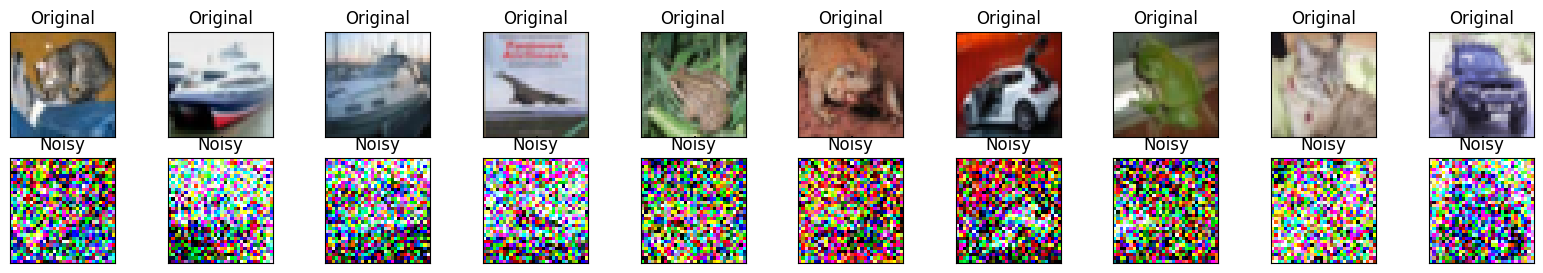

In [13]:
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    # gambara asli
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # gambar berisik
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Membangun Arsitektur Autoencoder

In [14]:
# input gambar
input_img = Input(shape=(32, 32, 3))

# --- Encoder ---
# lapisan konvolusi pertama
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x) # pooling size 2x2 mengurangi tinggi & lebar jadi setengahnya
# Output: 16x16x32 ()

# Conv2D(32, (3,3), input_shape=(32,32,3))
# (filter_height×filter_width×input_channels×output_channels)+output_channel
# (3×3×3×32)+32=(9×3×32)+32=(9×96)+32=864+32=896

# lapisan konvolusi kedua
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# Output: 8x8x32

# input channel = 32
# (3×3×32×32)+32=(9×32×32)+32=(9×1024)+32=9216+32=924

# --- Decoder ---
# lapisan dekonvolusi (UpSampling2D + Conv2D)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x) # Output: 16x16x32

# lapisan dekonvolosi kedua
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # Output: 32x32x32

# lapisaan output (sigmoid untuk gambar dinormalisasi [0,1])
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
# channel RGB 

# buat model Autoencoder
autoencoder = Model(input_img, decoded)

# tampilkkan ringkasan arsitektur model
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,507 (115.26 KB)

 Trainable params: 29,507 (115.26 KB)

 Non-trainable params: 0 (0.00 B)

## Kompilasi Model

In [15]:
autoencoder.compile(optimizer='adam', loss='mse') # MSE sebagai loss umum untuk denoising

In [16]:
epochs = 100 
batch_size = 128

# penggunaan early_stopping untuk mencegah overfitting dan menghemat waktu
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, # proses berhenti jika val_loss tidak membaik selama 5 epoch
                               restore_best_weights=True)

history = autoencoder.fit(x_train_noisy, x_train, # input: gambar berisik | target: gambar bersih
                          epochs=epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test),
                          callbacks=[early_stopping])

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0262 - val_loss: 0.0153
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0150 - val_loss: 0.0145
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0131 - val_loss: 0.0130
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0130 - val_loss: 0.0129
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 10/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 11/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 12/100
391/391 ━━━━━━━━━━━━━━━━━━━

## Evaluasi Hasil dan Visualisasi

In [17]:
# prrediksi gambar bersih dari gambar bernoise pada test set
decoded_imgs = autoencoder.predict(x_test_noisy)

# visualisasi hasil pelatihan (yang loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


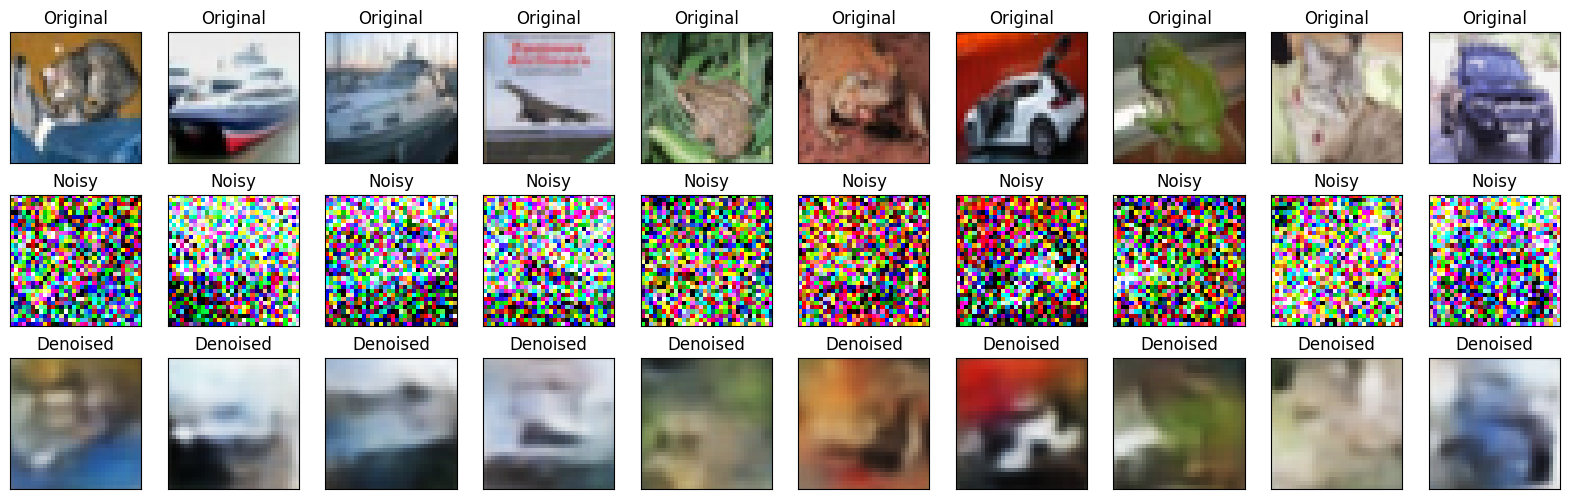

In [22]:
# visualisasi beberapa contoh hasil denoisin
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # gambar asli
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # gambar noise
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # gambar hasil denoising
    ax = plt.subplot(3, n, i + 1 + n * 2)
    plt.imshow(decoded_imgs[i])
    plt.title("Denoised")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()